In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import tensorflow as tf
from xgboost import plot_importance
from xgboost import plot_tree
from tensorflow.keras.callbacks import TensorBoard
from math import sqrt
#from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
# load data from file
data = pd.read_csv('match_data_avg_stats.csv', header=0)

# inspect the dataframe
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,...,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,...,-0.002514,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,...,-0.487157,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,...,-0.217585,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,...,-0.296455,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,...,NaN,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6460 entries, 0 to 6459
Data columns (total 49 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     6460 non-null   int64  
 1   homeID                 6460 non-null   int64  
 2   awayID                 6460 non-null   int64  
 3   home_name              6460 non-null   object 
 4   away_name              6460 non-null   object 
 5   date                   6460 non-null   object 
 6   season                 6460 non-null   object 
 7   status                 6460 non-null   object 
 8   homeGoalCount          6460 non-null   int64  
 9   awayGoalCount          6460 non-null   int64  
 10  totalGoalCount         6460 non-null   int64  
 11  team_a_cards_num       6460 non-null   int64  
 12  team_b_cards_num       6460 non-null   int64  
 13  odds_ft_1              6460 non-null   float64
 14  odds_ft_x              6460 non-null   float64
 15  odds

In [4]:
# drop matches with "incomplete" or "suspended" status
data = data[data['status'] == 'complete']

In [5]:
# check shape of data
data.shape

(6278, 49)

In [6]:
# Get the shape (number of rows and columns) where the 'team_a_xg_prematch' column is equal to 0
data[data['team_a_xg_prematch']==0].shape

(3609, 49)

In [7]:
# Get the shape (number of rows and columns) where the 'team_b_xg_prematch' column is equal to 0
data[data['team_b_xg_prematch']==0].shape

(3609, 49)

In [8]:
# Get the shape (number of rows and columns) where the 'total_xg_prematch' column is equal to 0
data[data['total_xg_prematch']==0].shape

(3603, 49)

In [9]:
# check entries with values == 0
columns_to_drop = ['team_a_xg_prematch', 'team_b_xg_prematch', 'total_xg_prematch']


In [10]:
# drop columns with missing values
data.drop(columns=columns_to_drop, inplace=True)

<ipython-input-10-f1878ef2c43b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=columns_to_drop, inplace=True)


In [11]:
# inspect the first few rows of data dataframe
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,...,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,...,-0.002514,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,...,-0.487157,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,...,-0.217585,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,...,-0.296455,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,...,NaN,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667


In [12]:
def winningTeam(row):
    # Extracting the goal counts for the home and away teams from the row
    homeGoalCount = row['homeGoalCount']
    awayGoalCount = row['awayGoalCount']

    # Checking which team won based on the goal counts
    if homeGoalCount > awayGoalCount:
        return 1  # 1 means home team won
    elif awayGoalCount > homeGoalCount:
        return 2  # 2 means away team won
    else:
        return 0  # 0 indicates a draw


In [13]:
# Apply the winningTeam function to each row of the dataframe
data['1x2'] = data.apply(lambda row: winningTeam(row), axis=1)

<ipython-input-13-4e038c1ef04f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['1x2'] = data.apply(lambda row: winningTeam(row), axis=1)


In [14]:
# check for missing values in the ppg columns
data[data['away_ppg']==0].shape

(0, 47)

In [15]:
data[data['odds_ft_1']==0].shape

(1915, 47)

In [16]:
# check shape of dataframe
data.shape

(6278, 47)

In [17]:
# drop entries where odds is zero
cleaned_data = data.drop(index=data[data['odds_ft_1']==0].index)

In [18]:
# check size of new dataframe
cleaned_data.shape

(4363, 47)

In [19]:
# inspect column to check that entries with zeros have been dropped
cleaned_data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,...,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away,1x2
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,...,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667,1
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,...,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333,2
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,...,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667,2
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,...,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667,0
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,...,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667,0


In [20]:
# get dataframe info
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4363 entries, 0 to 6279
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4363 non-null   int64  
 1   homeID                 4363 non-null   int64  
 2   awayID                 4363 non-null   int64  
 3   home_name              4363 non-null   object 
 4   away_name              4363 non-null   object 
 5   date                   4363 non-null   object 
 6   season                 4363 non-null   object 
 7   status                 4363 non-null   object 
 8   homeGoalCount          4363 non-null   int64  
 9   awayGoalCount          4363 non-null   int64  
 10  totalGoalCount         4363 non-null   int64  
 11  team_a_cards_num       4363 non-null   int64  
 12  team_b_cards_num       4363 non-null   int64  
 13  odds_ft_1              4363 non-null   float64
 14  odds_ft_x              4363 non-null   float64
 15  odds

In [21]:
# Define a list of columns to be dropped from the DataFrame
columns_to_drop = ['id', 'homeID', 'awayID', 'date',
                   'status','season','home_name','away_name']

# Drop the specified columns from the DataFrame
cleaned_data = cleaned_data.drop(columns=columns_to_drop)

In [22]:
# inspect cleaned dataset to confirm columns were dropped successfully
cleaned_data.head()

,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,...,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away,1x2
0,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,...,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667,1
1,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,...,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333,2
2,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,...,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667,2
3,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,...,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667,0
4,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,...,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667,0


In [23]:
cleaned_data.columns

Index(['homeGoalCount', 'awayGoalCount', 'totalGoalCount', 'team_a_cards_num',
       'team_b_cards_num', 'odds_ft_1', 'odds_ft_x', 'odds_ft_2', 'home_ppg',
       'away_ppg', 'xG_home', 'xG_away', 'xGA_home', 'xGA_away', 'npxG_home',
       'npxG_away', 'npxGA_home', 'npxGA_away', 'deep_home', 'deep_away',
       'deep_allowed_home', 'deep_allowed_away', 'scored_home', 'scored_away',
       'missed_home', 'missed_away', 'xpts_home', 'xpts_away', 'npxGD_home',
       'npxGD_away', 'ppda.att_home', 'ppda.att_away', 'ppda.def_home',
       'ppda.def_away', 'ppda_allowed.att_home', 'ppda_allowed.att_away',
       'ppda_allowed.def_home', 'ppda_allowed.def_away', '1x2'],
      dtype='object')

In [24]:
# check for null values
cleaned_data.isnull().sum()

homeGoalCount              0
awayGoalCount              0
totalGoalCount             0
team_a_cards_num           0
team_b_cards_num           0
odds_ft_1                  0
odds_ft_x                  0
odds_ft_2                  0
home_ppg                   0
away_ppg                   0
xG_home                  659
xG_away                  774
xGA_home                 659
xGA_away                 774
npxG_home                659
npxG_away                774
npxGA_home               659
npxGA_away               774
deep_home                659
deep_away                774
deep_allowed_home        659
deep_allowed_away        774
scored_home              659
scored_away              774
missed_home              659
missed_away              774
xpts_home                659
xpts_away                774
npxGD_home               659
npxGD_away               774
ppda.att_home            659
ppda.att_away            774
ppda.def_home            659
ppda.def_away            774
ppda_allowed.a

In [25]:
# drop null values
cleaned_data.dropna(inplace=True)

In [26]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3026 entries, 0 to 6278
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   homeGoalCount          3026 non-null   int64  
 1   awayGoalCount          3026 non-null   int64  
 2   totalGoalCount         3026 non-null   int64  
 3   team_a_cards_num       3026 non-null   int64  
 4   team_b_cards_num       3026 non-null   int64  
 5   odds_ft_1              3026 non-null   float64
 6   odds_ft_x              3026 non-null   float64
 7   odds_ft_2              3026 non-null   float64
 8   home_ppg               3026 non-null   float64
 9   away_ppg               3026 non-null   float64
 10  xG_home                3026 non-null   float64
 11  xG_away                3026 non-null   float64
 12  xGA_home               3026 non-null   float64
 13  xGA_away               3026 non-null   float64
 14  npxG_home              3026 non-null   float64
 15  npxG

## **Data Preprocessing**




Let's commence by visualizing the correlation among our variables to assess the presence of multicollinearity.

In [27]:
correlation_matrix = cleaned_data.corr()

# Set a correlation threshold
correlation_threshold = 0.8

# Find highly correlated features
highly_correlated_features = np.where(np.abs(correlation_matrix) > correlation_threshold)

# Get unique feature pairs to avoid duplication
unique_correlations = [(correlation_matrix.columns[i], correlation_matrix.columns[j])
                       for i, j in zip(*highly_correlated_features) if i != j and i < j]

print("Highly Correlated Feature Pairs:")
for feature_pair in unique_correlations:
    print(f"{feature_pair[0]} and {feature_pair[1]} with correlation {correlation_matrix.loc[feature_pair[0], feature_pair[1]]}")

Highly Correlated Feature Pairs:
odds_ft_x and odds_ft_2 with correlation 0.8076707822890407
xG_home and npxG_home with correlation 0.9790817005868561
xG_home and scored_home with correlation 0.8027175229118294
xG_home and xpts_home with correlation 0.9288684587286042
xG_home and npxGD_home with correlation 0.8942368659209031
xG_away and npxG_away with correlation 0.9814269810730257
xG_away and deep_away with correlation 0.8109790232254047
xG_away and scored_away with correlation 0.8450018141338475
xG_away and xpts_away with correlation 0.900890486942434
xG_away and npxGD_away with correlation 0.8906568996361799
xGA_home and npxGA_home with correlation 0.9752637905207504
xGA_home and xpts_home with correlation -0.8305737826851592
xGA_home and npxGD_home with correlation -0.8660399432373519
xGA_away and npxGA_away with correlation 0.9764306031794452
xGA_away and xpts_away with correlation -0.8249024248939965
xGA_away and npxGD_away with correlation -0.8350672030490804
npxG_home and scor

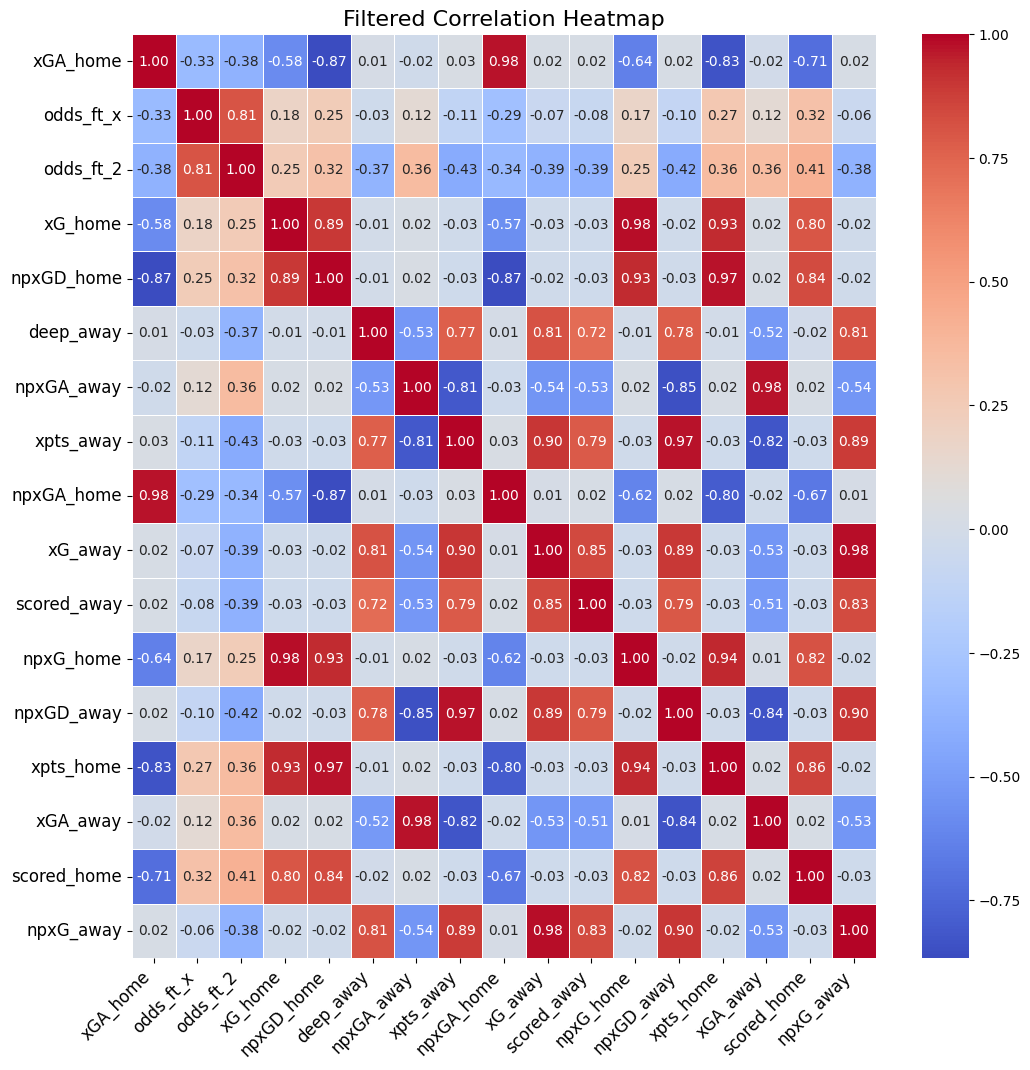

In [28]:
# create a new DataFrame with only the selected features
selected_features = list(set(feature for pair in unique_correlations for feature in pair))
filtered_data = cleaned_data[selected_features]

# Visualize the filtered correlation matrix
plt.figure(figsize=(12, 12))
sns.heatmap(filtered_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title("Filtered Correlation Heatmap", fontsize=16)
plt.show()

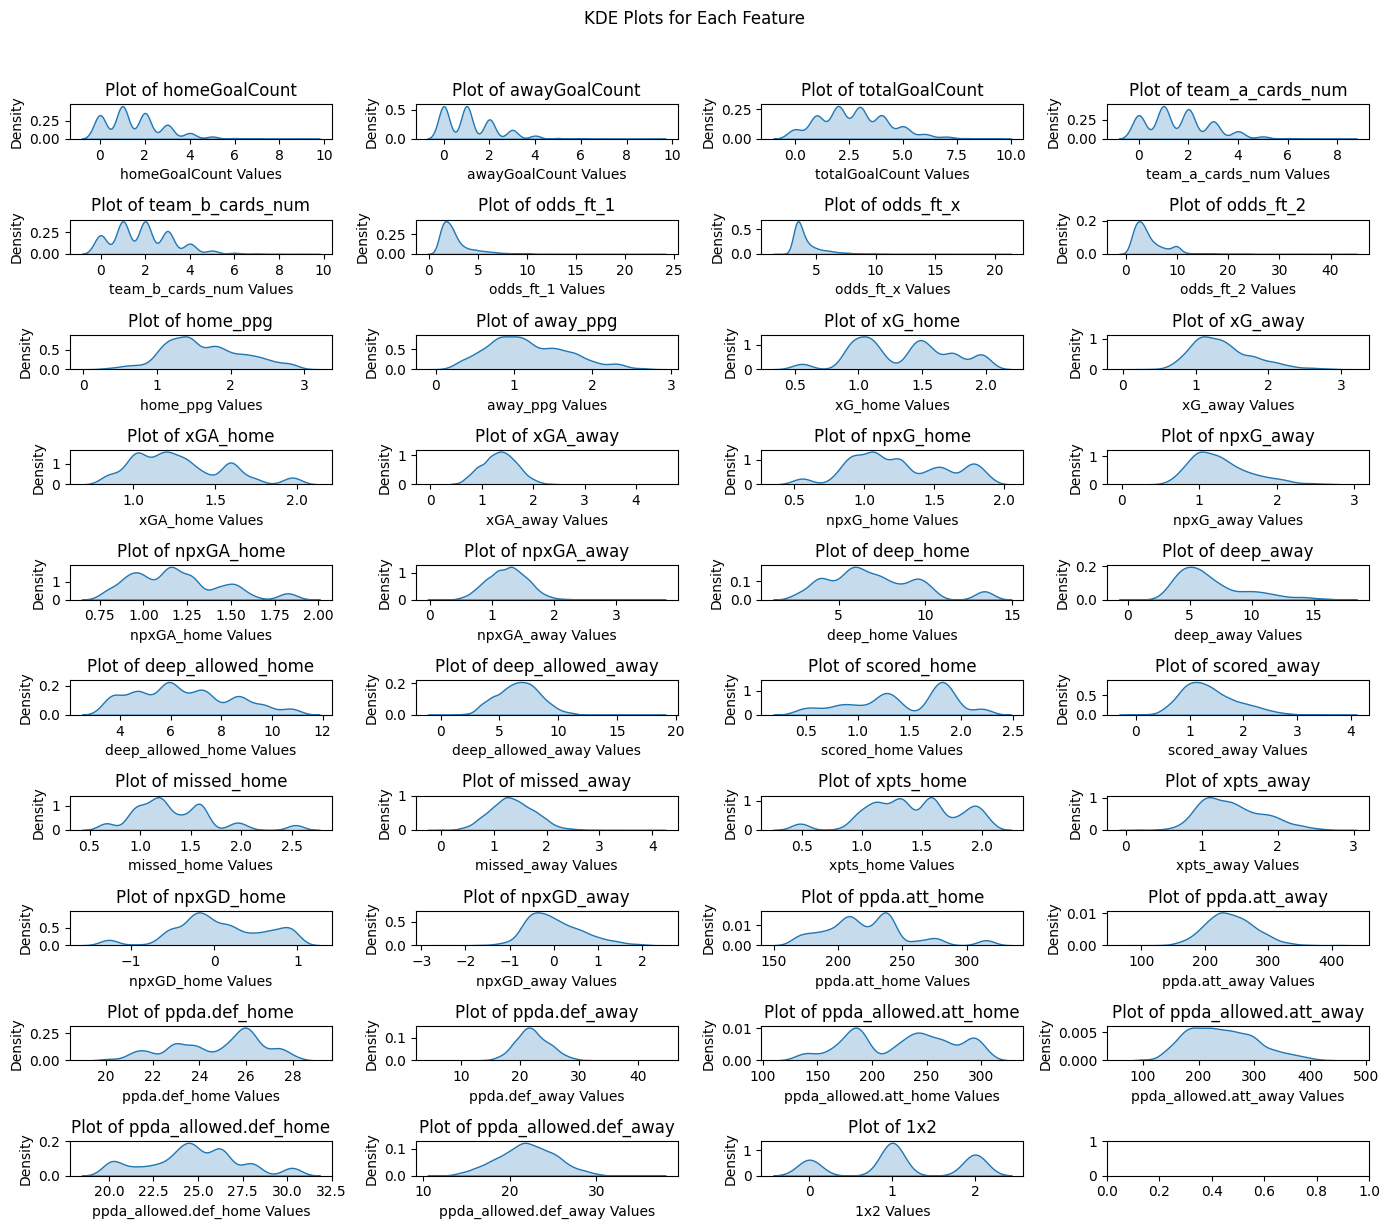

In [29]:
features = cleaned_data.columns.tolist()

# Set up subplots
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(14, 12))
fig.suptitle('KDE Plots for Each Feature', y=1.02)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through features and create KDE plots or count plots
for i, feature in enumerate(features):
    if cleaned_data[feature].dtype == 'O':
        sns.countplot(x=feature, data=cleaned_data, ax=axes[i])
    else:
        sns.kdeplot(x=cleaned_data[feature], fill=True, ax=axes[i])

    axes[i].set_title(f'Plot of {feature}')
    axes[i].set_xlabel(f'{feature} Values')
    axes[i].set_ylabel('Density' if cleaned_data[feature].dtype != 'O' else 'Count')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

The observed correlation analysis reveals significant associations among our features:

- "odds_ft_x" and "odds_ft_2" exhibit a correlation of 0.81, indicating a substantial linear relationship.
- "xG_home" showcases high correlation with various features, such as "npxG_home" (correlation of 0.98), "scored_home" (correlation of 0.80), and "xpts_home" (correlation of 0.93).
- Similarly, "xG_away" exhibits strong correlations with "npxG_away" (correlation of 0.98), "deep_away" (correlation of 0.81), and others.

Additionally, certain defensive metrics like "xGA_home" and "xGA_away" display strong negative correlations with their corresponding offensive counterparts, indicating an inverse relationship.

These findings emphasize the presence of multicollinearity among the features, suggesting potential redundancies or interdependencies.

To mitigate multicollinearity, we will leverage Recursive Feature Elimination (RFE) to intelligently select a subset of features. In addition, during the model development phase, we will incorporate regularization techniques. This entails carefully choosing a subset of features or applying regularization methods to enhance the stability and interpretability of our models in the presence of correlated predictors.

The majority of features in the dataset display characteristics consistent with a normal distribution.

<Axes: ylabel='totalGoalCount'>

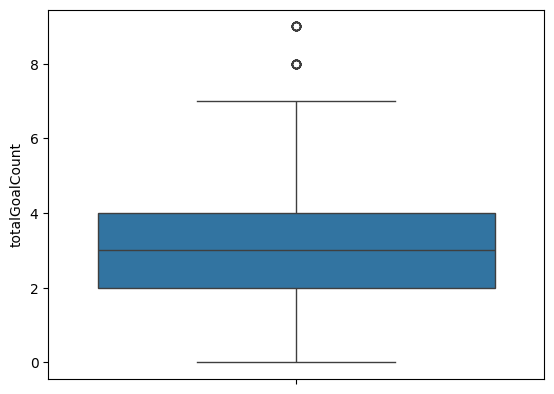

In [30]:
sns.boxplot(cleaned_data['totalGoalCount'])

In [31]:
cleaned_data = cleaned_data[cleaned_data['totalGoalCount'] < 8]

In [32]:
# defining target and feature variables
target = cleaned_data[["totalGoalCount"]]
features = cleaned_data.drop(columns = ["totalGoalCount",'homeGoalCount', 'awayGoalCount',
                   'team_a_cards_num', 'team_b_cards_num','1x2'],axis = 1)


In [33]:
# split our dataset
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size = 0.20,random_state = 42)

In [34]:
# instantiate a scaler
scaler = StandardScaler()

# fit and transform the scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Commencing with the establishment of a baseline model, we opt for Linear Regression.

In [35]:
# baseline model
lr = LinearRegression()

Recursive Feature Elimination (RFE) is a feature selection technique that recursively removes features from the dataset while fitting a model on the remaining features. The main idea behind RFE is to repeatedly train a model, evaluate the importance of each feature, and eliminate the least important features until the desired number of features is reached.

RFE helps in automating the feature selection process and can be useful in reducing the dimensionality of the dataset, improving model interpretability, and potentially enhancing model generalization performance by focusing on the most relevant features.

In [36]:
# recursive feature elimination
rfe = RFE(estimator = lr,step = 2)
# fit the model
rfe.fit(X_train_scaled,y_train)

RFE(estimator=LinearRegression(), step=2)

In [37]:
rfe.n_features_

16

In [38]:
rfe.support_

array([ True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True, False, False,  True, False, False, False,  True,
        True,  True, False,  True, False, False, False, False,  True,
       False, False, False, False, False,  True])

In [39]:
#selected columns
selected_columns = X_train.columns[rfe.support_]
selected_columns

Index(['odds_ft_1', 'odds_ft_x', 'odds_ft_2', 'xG_home', 'xG_away', 'xGA_home',
       'xGA_away', 'npxG_home', 'npxG_away', 'deep_home', 'scored_home',
       'scored_away', 'missed_home', 'xpts_home', 'ppda.att_away',
       'ppda_allowed.def_away'],
      dtype='object')

In [40]:
feature_ranking = rfe.ranking_

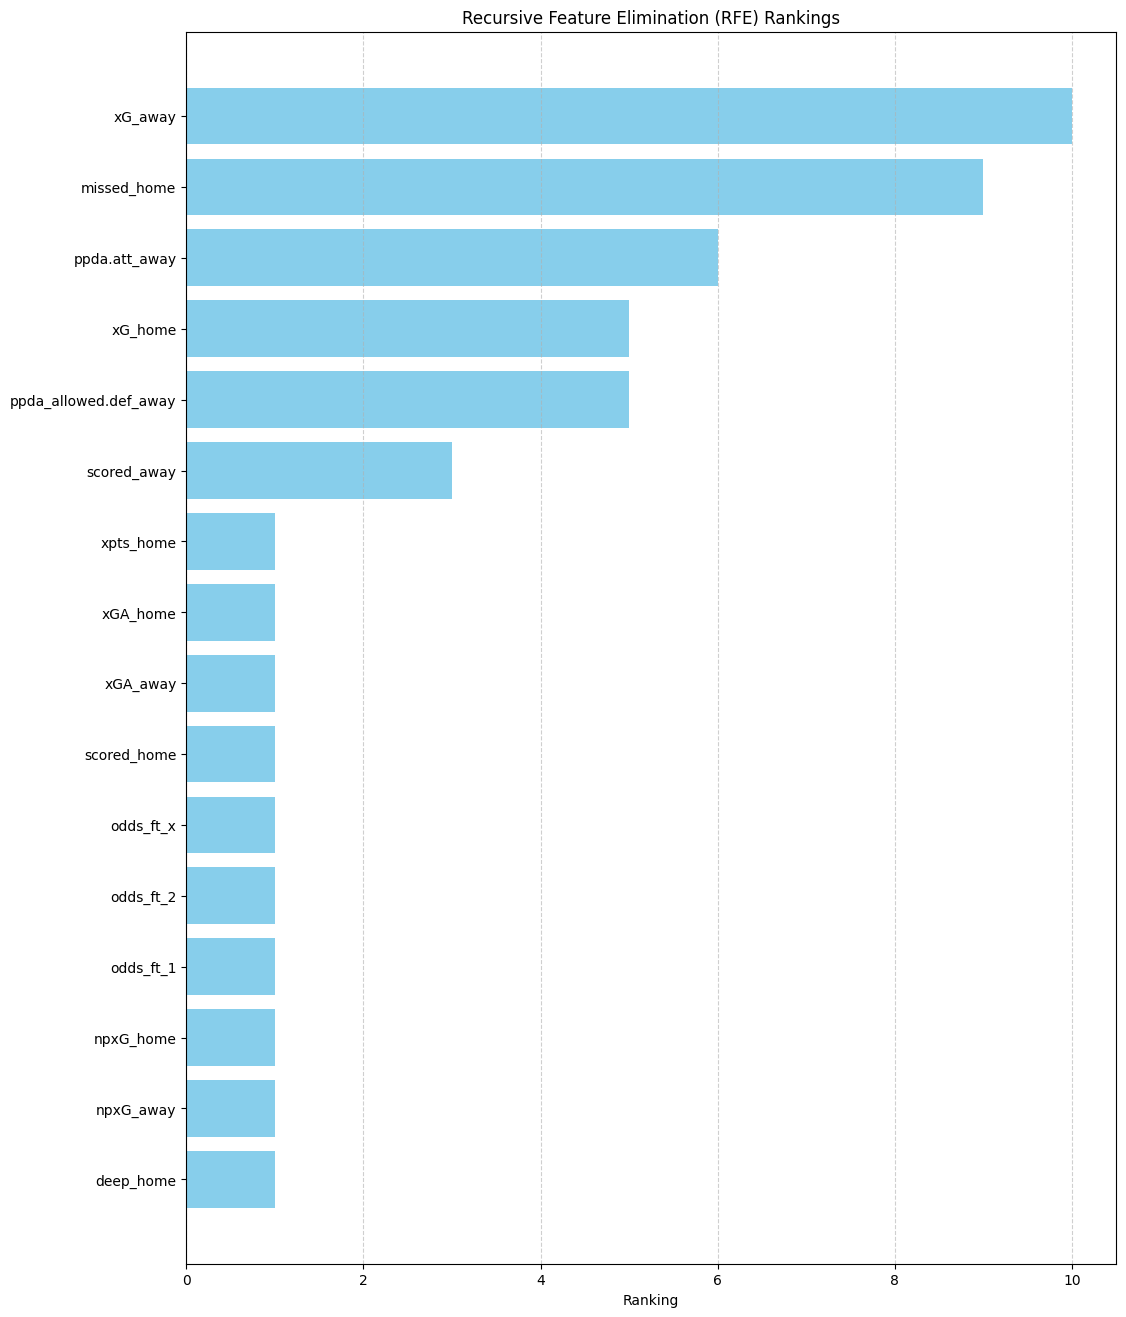

In [41]:
# Sort features based on their ranking
sorted_features = [feature for _, feature in sorted(zip(feature_ranking[:len(selected_columns)], selected_columns))]

# Create a bar plot with adjusted figure size and label rotation
plt.figure(figsize=(12, 16))
plt.barh(range(len(sorted_features)), np.sort(feature_ranking[:len(selected_columns)]), align='center', color='skyblue')
plt.yticks(range(len(sorted_features)), sorted_features, rotation=0, ha='right')  # Rotate labels
plt.xlabel('Ranking')
plt.title('Recursive Feature Elimination (RFE) Rankings')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


The plot provides a visual representation of the importance of each feature according to the RFE algorithm.The lower the rank, the more important the feature is considered by the RFE algorithm.

# Baseline Model using our selected features

Utilizing the features selected through Recursive Feature Elimination (RFE), we construct a baseline linear regression model. The coefficients and intercept of the model are extracted for examination. Subsequently, predictions are made on the test set, and the Mean Absolute Error (MAE) is computed to evaluate the model's performance.

In [42]:
# Retrieve the selected feature indices from RFE
selected_feature_indices = rfe.support_

# Extract the selected features for both the training and test sets
selected_features = X_train_scaled[:, selected_feature_indices]
selected_features_test = X_test_scaled[:, selected_feature_indices]

# Create a Linear Regression model
lr_baseline_model = LinearRegression()

# Fit the model on the selected features and target variable (training set)
baseline_model = lr_baseline_model.fit(selected_features, y_train)

# Obtain the coefficients and intercept of the baseline model
coefficients = baseline_model.coef_
intercept = baseline_model.intercept_

# Make predictions on the test set
y_pred_baseline = baseline_model.predict(selected_features_test)

# Evaluate the model performance using Mean Absolute Error (MAE)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
mse_baseline = mean_squared_error(y_test,y_pred_baseline)
rmse_baseline = sqrt(mse_baseline)

# Display the coefficients and intercept
print("Coefficients:", coefficients)
print()
print("Intercept:", intercept)

# Display the Metrics on the test set
print()
print("Mean Absolute Error on Test Data (Baseline):", mae_baseline)
print("Mean Squared Error on Test Data (Baseline):" , mse_baseline)
print("Root Mean Squared Error on Test Data(Baseline):", rmse_baseline)

Coefficients: [[ 0.06733361  0.11033407  0.13312884  0.60678094  0.30618131 -0.34807726
   0.10547067 -0.11244866 -0.09118042  0.08013842 -0.0484671  -0.10848184
   0.14637506 -0.58459189 -0.09358006  0.09770062]]

Intercept: [2.74708333]

Mean Absolute Error on Test Data (Baseline): 1.2998214519761802
Mean Squared Error on Test Data (Baseline): 2.502710953465454
Root Mean Squared Error on Test Data(Baseline): 1.5819958765639859


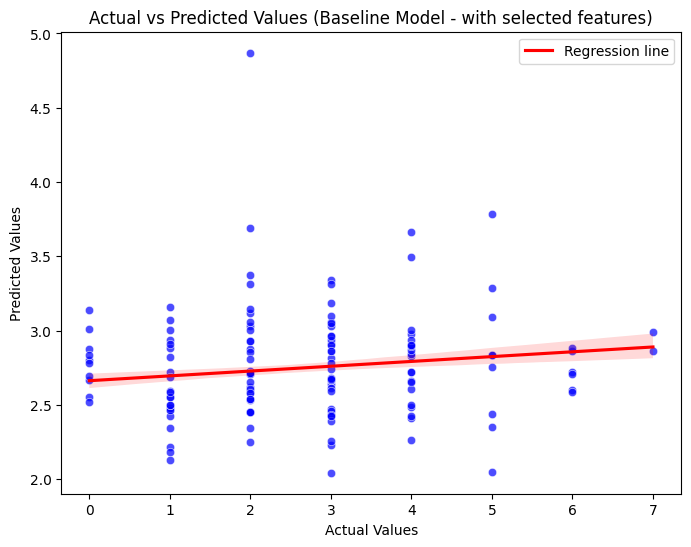

In [43]:
# Convert y_pred_baseline to a Pandas DataFrame with a single column
y_pred_baseline_df = pd.DataFrame(y_pred_baseline, columns=['totalGoalCount'])


# Extract the 'totalGoalCount' column from y_test
y_test_1d = y_test['totalGoalCount']

# Extract the 'totalGoalCount' column from y_pred_baseline_df
y_pred_baseline_1d = y_pred_baseline_df['totalGoalCount']

# Set up the plot
plt.figure(figsize=(8, 6))

# Create a scatter plot
sns.scatterplot(x=y_test_1d, y=y_pred_baseline_1d, color='blue', alpha=0.7)


# Add a regression line (optional)
sns.regplot(x=y_test_1d, y=y_pred_baseline_1d, scatter=False, color='red',label = "Regression line")

# Customize labels and title
plt.title('Actual vs Predicted Values (Baseline Model - with selected features)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Show the plot
plt.legend()
plt.show()

The Mean Absolute Error (MAE) of approximately 1.35 suggests that, on average, the predictions of total goal counts deviate by approximately 1 goal from the actual values. The scatter plot visualization reinforces this observation, as the points exhibit a noticeable deviation from the regression line.

The elevated MAE value indicates a potential underfitting phenomenon, implying that the model may struggle to capture intricate patterns and complexities inherent in the data.

To address potential overfitting in our model, we'll introduce a regularization technique. Specifically, we will apply Ridge penalization, chosen for its property of not setting the coefficients to zero. It's noteworthy that we've already conducted feature selection using Recursive Feature Elimination (RFE).

In [44]:
# Define the Ridge model
tuned_ridge_model = Ridge()

# Define the hyperparameter grid for Ridge
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
    'random_state': [42],
    'max_iter': [100, 500, 1000, 2000],
    'tol': [1e-4, 1e-3, 1e-2]
}

# Create the GridSearchCV object for Ridge
grid_search_ridge = GridSearchCV(estimator=tuned_ridge_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)

# Fit the grid search to the data
grid_search_ridge.fit(selected_features, y_train)

# Get the best hyperparameters for Ridge
best_params_ridge = grid_search_ridge.best_params_
print("Best Hyperparameters for Ridge:", best_params_ridge)

# Get the best Ridge model
best_ridge_model = grid_search_ridge.best_estimator_


# Predict using the best Ridge model
y_pred_ridge = best_ridge_model.predict(selected_features_test)

# Evaluate the Ridge model
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test,y_pred_ridge)
rmse_ridge = sqrt(mse_ridge)

print()
print("Mean Absolute Error on Test Data (Ridge):", mae_ridge)
print("Mean Squared Error on Test Data (Ridge):", mse_ridge)
print("Root Mean Squared Error on Test Data(Ridge):", rmse_ridge)

Best Hyperparameters for Ridge: {'alpha': 10.0, 'fit_intercept': True, 'max_iter': 100, 'random_state': 42, 'tol': 0.0001}

Mean Absolute Error on Test Data (Ridge): 1.2959510807341783
Mean Squared Error on Test Data (Ridge): 2.49143106088024
Root Mean Squared Error on Test Data(Ridge): 1.5784267676646389


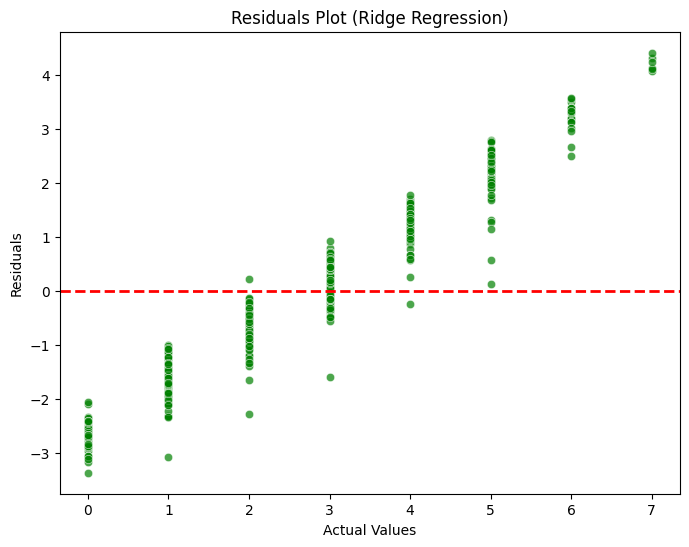

In [45]:
# Calculate residuals
residuals_ridge = y_test - y_pred_ridge


# Set up the plot
plt.figure(figsize=(8, 6))

# Create a scatter plot of residuals
sns.scatterplot(x=y_test['totalGoalCount'], y=residuals_ridge['totalGoalCount'], color='green', alpha=0.7)

# Add a horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

# Customize labels and title
plt.title('Residuals Plot (Ridge Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')

# Show the plot
plt.show()



The Ridge model with optimized hyperparameters, including an alpha value of 10.0, fit_intercept set to True, maximum iterations of 100, a random state of 42, and a tolerance of 0.0001, resulted in a decreased Mean Absolute Error (MAE) of 1.3473 on the test data. This reduction in MAE indicates a modest improvement in the model's performance, suggesting that the regularization introduced by Ridge has helped mitigate overfitting and enhance the predictive accuracy on the test set.

# Random Forest Model

Since Random forest has feature iimportance,we are going to use X_train scaled as our features and compare with selected features from RFE.

In [46]:
# Create the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

# Define hyperparameters to tune
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
# Use GridSearchCV to find the best hyperparameters
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='neg_mean_absolute_error')
grid_search_rf.fit(X_train_scaled, y_train.values.ravel())

# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_

# Train the model with the best hyperparameters
best_rf_model = RandomForestRegressor(**best_params_rf, random_state=42)
best_rf_model.fit(X_train_scaled, y_train.values.ravel())

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test_scaled)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test,y_pred_rf)
rmse_rf = sqrt(mse_rf)

print("Best Hyperparameters:", best_params_rf)
print()
print("Mean Absolute Error on Test Data (RandomForest Regressor):", mae_rf)
print("Mean Squared Error on Test Data (RandomForest Regressor):", mse_rf)
print("Root Mean Squared Error on Test Data(RandomForest Regressor):", rmse_rf)



Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Mean Absolute Error on Test Data (RandomForest Regressor): 1.3023927288065351
Mean Squared Error on Test Data (RandomForest Regressor): 2.518440303612917
Root Mean Squared Error on Test Data(RandomForest Regressor): 1.5869594524161343


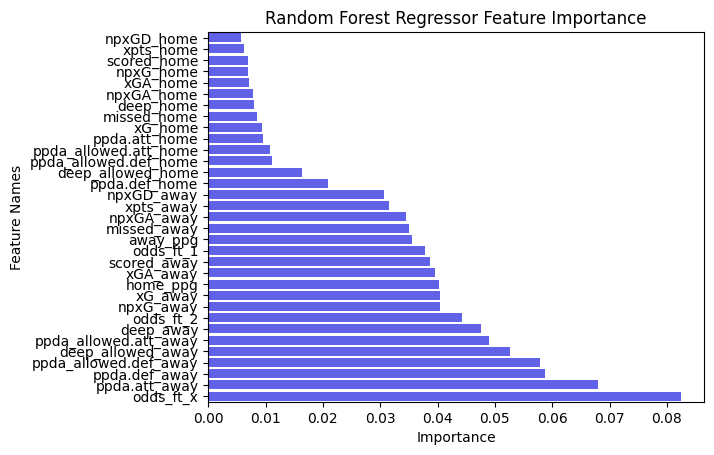

In [47]:
feature_importances = best_rf_model.feature_importances_
feature_names = X_train.columns

# Sort the indices based on feature importances
indices = np.argsort(feature_importances)

# Plot the sorted feature importances
sns.barplot(x=feature_importances[indices], y=feature_names[indices], color='blue', alpha=0.7)
plt.title('Random Forest Regressor Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature Names')
plt.show()

In [48]:
uncommon_features = [feature for feature in selected_columns if feature in feature_importances]
uncommon_features

<ipython-input-48-aa35f1825bd3>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  uncommon_features = [feature for feature in selected_columns if feature in feature_importances]


[]

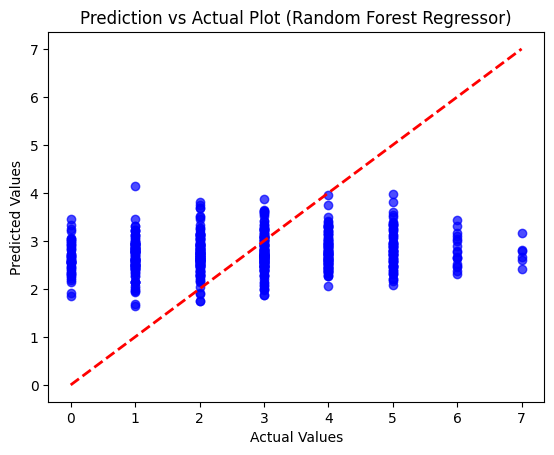

In [49]:
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.7)
plt.plot([min(y_test['totalGoalCount']), max(y_test['totalGoalCount'])], [min(y_test['totalGoalCount']), max(y_test['totalGoalCount'])], linestyle='--', color='red', linewidth=2)
plt.title('Prediction vs Actual Plot (Random Forest Regressor)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


In [50]:
# # features_to_plot = [
#     'odds_ft_2',
#     'home_ppg',
#     'away_ppg',
#     'xG_home',
#     'xG_away',
#     'xGA_home',
#     'xGA_away',
#     'npxG_home',
#     'npxG_away']

# plot_partial_dependence(rf_model, X_train_scaled, features_to_plot, grid_resolution=50)
#plt.suptitle('Partial Dependence Plots (Random Forest Regressor)')
#plt.show()


In [51]:
# Create the XGBRegressor model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_xgb_model = XGBRegressor(**best_params, random_state=42)
best_xgb_model.fit(X_train_scaled, y_train,
                   eval_set=[(X_test_scaled, y_test)],
                   eval_metric='mae',
                   early_stopping_rounds=10,
                   verbose=True)

# Make predictions on the test set
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test,y_pred_xgb)
rmse_xgb = sqrt(mse_xgb)

print()
print("Mean Absolute Error on Test Data (XGB):", mae_xgb)
print("Mean Squared Error on Test Data (XGB):", mse_xgb)
print("Root Mean Squared Error on Test Data(XGB):", rmse_xgb)



[0]	validation_0-mae:1.30989
[1]	validation_0-mae:1.30578
[2]	validation_0-mae:1.30275
[3]	validation_0-mae:1.30161
[4]	validation_0-mae:1.30059
[5]	validation_0-mae:1.29942
[6]	validation_0-mae:1.29612
[7]	validation_0-mae:1.29470
[8]	validation_0-mae:1.29309
[9]	validation_0-mae:1.29274
[10]	validation_0-mae:1.29246
[11]	validation_0-mae:1.29221
[12]	validation_0-mae:1.29249
[13]	validation_0-mae:1.29211
[14]	validation_0-mae:1.29208
[15]	validation_0-mae:1.29187
[16]	validation_0-mae:1.29301
[17]	validation_0-mae:1.29217
[18]	validation_0-mae:1.29073
[19]	validation_0-mae:1.29024
[20]	validation_0-mae:1.29169
[21]	validation_0-mae:1.29182
[22]	validation_0-mae:1.29185
[23]	validation_0-mae:1.29220
[24]	validation_0-mae:1.29225
[25]	validation_0-mae:1.29220
[26]	validation_0-mae:1.29254
[27]	validation_0-mae:1.29387
[28]	validation_0-mae:1.29470
[29]	validation_0-mae:1.29495

Mean Absolute Error on Test Data (XGB): 1.2902417222658793
Mean Squared Error on Test Data (XGB): 2.477155809

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


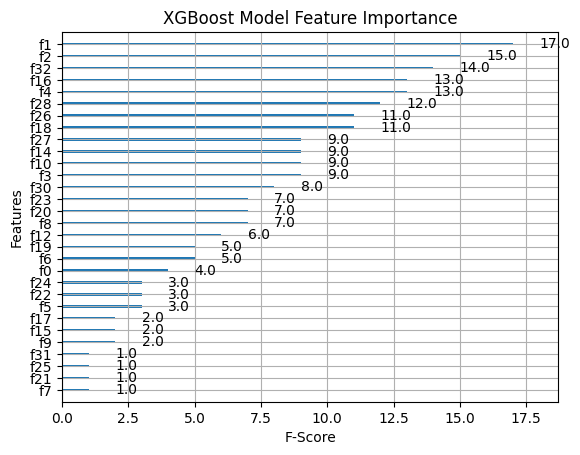

In [52]:
plot_importance(best_xgb_model,show_values = True)
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.title('XGBoost Model Feature Importance')
plt.show()

Number of Trees Used: 19


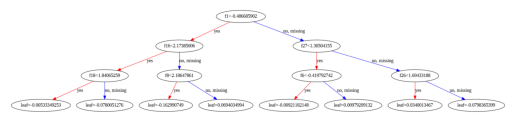

In [53]:
# # Access the number of trees used
# num_trees_used = best_xgb_model.get_booster().best_ntree_limit
# print(f'Number of Trees Used: {num_trees_used}')

# plot_tree(best_xgb_model, num_trees=0, rankdir='TB')
# plt.show()

# Access the number of trees used during early stopping
num_trees_used = best_xgb_model.get_booster().best_iteration
print(f'Number of Trees Used: {num_trees_used}')

# Plot a tree from the final iteration (you can adjust the num_trees parameter)
plot_tree(best_xgb_model, num_trees=num_trees_used-1, rankdir='TB')
plt.show()


In [54]:
# Create the SVR model
svr_model = SVR()

# Define hyperparameters to tune
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2]
}

y_train_array = y_train.values.ravel()
# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(selected_features, y_train_array)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_svr_model = SVR(**best_params)
best_svr_model.fit(selected_features, y_train_array)

# Make predictions on the test set
y_pred_svr = best_svr_model.predict(selected_features_test)

# Display the best hyperparameters
print('Best Hyperparameters:', best_params)

# Evaluate the model
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = sqrt(mse_svr)

print()
print("Mean Absolute Error on Test Data (SVR):", mae_svr)
print("Mean Squared Error on Test Data (SVR):", mse_svr)
print("Root Mean Squared Error on Test Data(SVR):", rmse_svr)

Best Hyperparameters: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Mean Absolute Error on Test Data (SVR): 1.2971175605179932
Mean Squared Error on Test Data (SVR): 2.5066209598946694
Root Mean Squared Error on Test Data(SVR): 1.5832311770220637


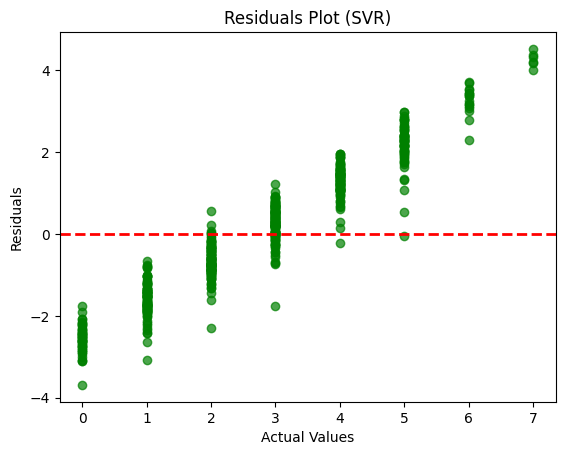

In [69]:
residuals_svr = y_test.to_numpy().reshape(-1,) - y_pred_svr

plt.scatter(y_test, residuals_svr, color='green', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals Plot (SVR)')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()


Text(0, 0.5, 'Predicted Values')

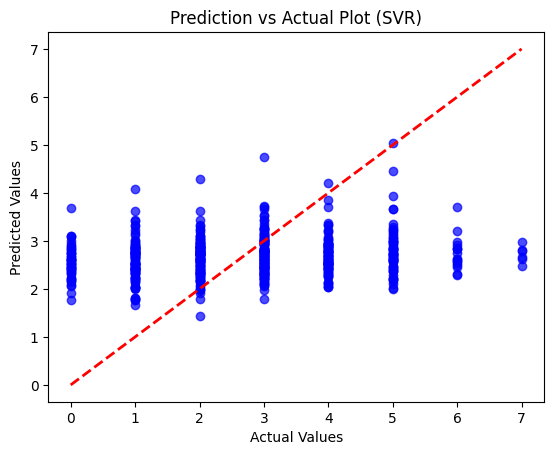

In [73]:
plt.scatter(y_test, y_pred_svr, color='blue', alpha=0.7)
plt.plot([min(y_test['totalGoalCount']), max(y_test['totalGoalCount'])], [min(y_test['totalGoalCount']), max(y_test['totalGoalCount'])], linestyle='--', color='red', linewidth=2)
plt.title('Prediction vs Actual Plot (SVR)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


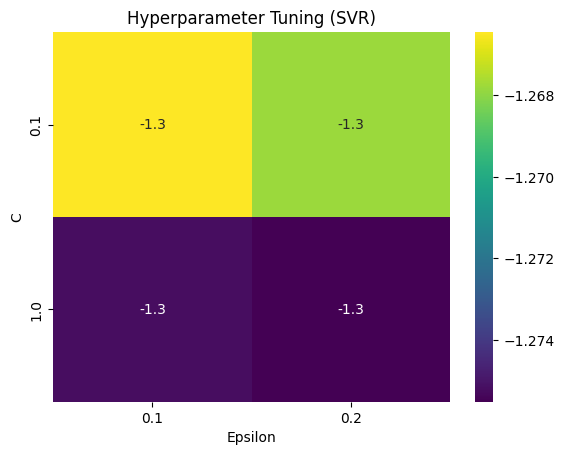

In [74]:
# Extract results for visualization
results = pd.DataFrame(grid_search.cv_results_)
# Visualize results, for example, using a heatmap
sns.heatmap(results.pivot_table(index='param_C', columns='param_epsilon', values='mean_test_score'), annot=True, cmap='viridis')
plt.title('Hyperparameter Tuning (SVR)')
plt.xlabel('Epsilon')
plt.ylabel('C')
plt.show()

In [76]:
# Build the deep neural network model
dn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.3),  # Add dropout for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Add dropout for regularization
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
dn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
dn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred_dn = dn_model.predict(X_test_scaled)


# Evaluate the model
mae_dn = mean_absolute_error(y_test, y_pred_dn)
mse_dn = mean_squared_error(y_test, y_pred_dn)
rmse_dn = sqrt(mse_dn)

dn_model.summary()


print()
print("Mean Absolute Error on Test Data (DN):", mae_dn)
print("Mean Squared Error on Test Data (DN):", mse_dn)
print("Root Mean Squared Error on Test Data(DN):", rmse_dn)

Epoch 1/50
60/60 [==============================] - 1s 6ms/step - loss: 3.9282 - val_loss: 2.6937
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 2.9849 - val_loss: 2.5559
Epoch 3/50
60/60 [==============================] - 0s 4ms/step - loss: 2.9393 - val_loss: 2.5417
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 2.8303 - val_loss: 2.4682
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 2.7031 - val_loss: 2.4362
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 2.6372 - val_loss: 2.4047
Epoch 7/50
60/60 [==============================] - 0s 4ms/step - loss: 2.6843 - val_loss: 2.4188
Epoch 8/50
60/60 [==============================] - 0s 3ms/step - loss: 2.6220 - val_loss: 2.4396
Epoch 9/50
60/60 [==============================] - 0s 4ms/step - loss: 2.6560 - val_loss: 2.4585
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 2.5486 - val_loss: 2.4190
Epoch 11/50
60/60 [

Epoch 1/50
60/60 [==============================] - 0s 4ms/step - loss: 2.2278 - val_loss: 2.4811
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 2.2818 - val_loss: 2.4849
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 2.2039 - val_loss: 2.5813
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 2.2021 - val_loss: 2.4630
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 2.1849 - val_loss: 2.6273
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 2.1955 - val_loss: 2.5036
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 2.1877 - val_loss: 2.5631
Epoch 8/50
60/60 [==============================] - 0s 4ms/step - loss: 2.2238 - val_loss: 2.5496
Epoch 9/50
60/60 [==============================] - 0s 4ms/step - loss: 2.1271 - val_loss: 2.5072
Epoch 10/50
60/60 [==============================] - 0s 7ms/step - loss: 2.1224 - val_loss: 2.5611
Epoch 11/50
60/60 [

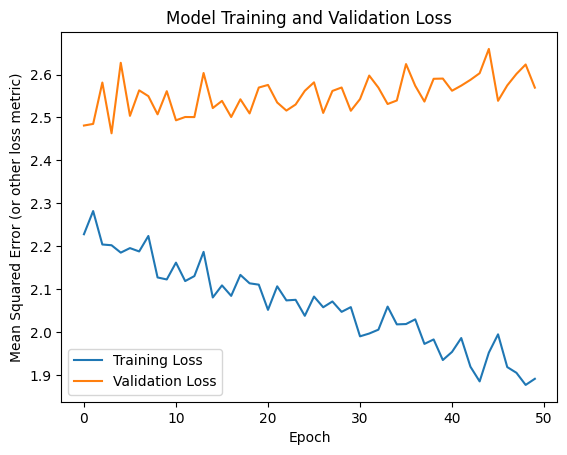

In [77]:
history = dn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (or other loss metric)')
plt.legend()
plt.show()



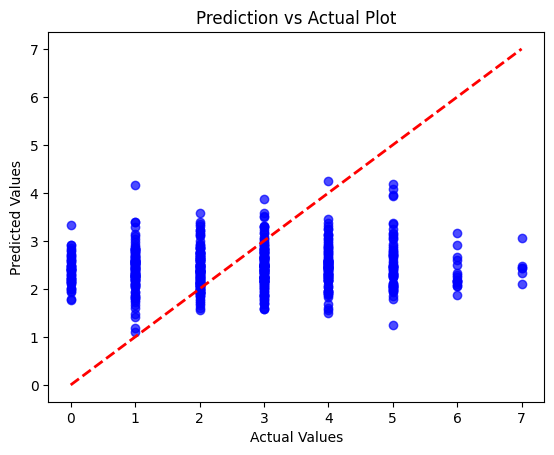

In [84]:
plt.scatter(y_test, y_pred_dn, color='blue', alpha=0.7)
plt.plot([min(y_test['totalGoalCount']), max(y_test['totalGoalCount'])], [min(y_test['totalGoalCount']), max(y_test['totalGoalCount'])], linestyle='--', color='red', linewidth=2)
plt.title('Prediction vs Actual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


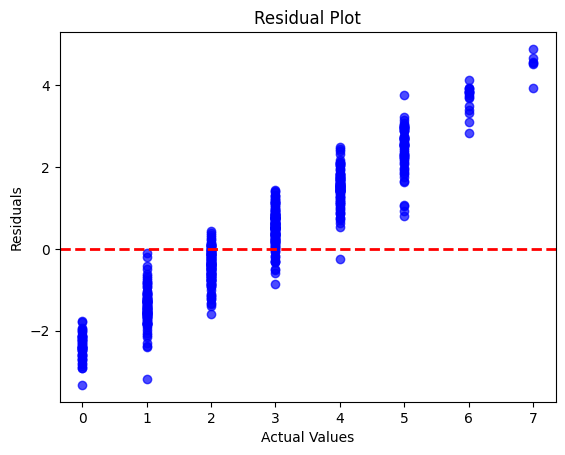

In [86]:
residuals = y_test - y_pred_dn

plt.scatter(y_test, residuals, color='blue', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()


In [87]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
dn_model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])


Epoch 1/50
75/75 [==============================] - 1s 7ms/step - loss: 2.1305 - val_loss: 13303.0410
Epoch 2/50
75/75 [==============================] - 0s 4ms/step - loss: 2.0358 - val_loss: 15144.1436
Epoch 3/50
75/75 [==============================] - 0s 4ms/step - loss: 2.0003 - val_loss: 13651.5518
Epoch 4/50
75/75 [==============================] - 0s 4ms/step - loss: 2.0762 - val_loss: 15630.5781
Epoch 5/50
75/75 [==============================] - 0s 4ms/step - loss: 2.0232 - val_loss: 17847.3867
Epoch 6/50
75/75 [==============================] - 0s 4ms/step - loss: 2.0080 - val_loss: 16504.1113
Epoch 7/50
75/75 [==============================] - 0s 4ms/step - loss: 2.0450 - val_loss: 17078.1367
Epoch 8/50
75/75 [==============================] - 0s 4ms/step - loss: 2.0033 - val_loss: 16104.9053
Epoch 9/50
75/75 [==============================] - 0s 4ms/step - loss: 2.0168 - val_loss: 13565.5303
Epoch 10/50
75/75 [==============================] - 0s 4ms/step - loss: 2.0139 - 

Epoch 1/50
75/75 [==============================] - 1s 11ms/step - loss: 1.7347 - val_loss: 9583.4082
Epoch 2/50
75/75 [==============================] - 1s 9ms/step - loss: 1.7285 - val_loss: 15543.4736
Epoch 3/50
75/75 [==============================] - 0s 7ms/step - loss: 1.7787 - val_loss: 12803.3691
Epoch 4/50
75/75 [==============================] - 1s 13ms/step - loss: 1.7518 - val_loss: 9142.0361
Epoch 5/50
75/75 [==============================] - 1s 13ms/step - loss: 1.7369 - val_loss: 9398.8730
Epoch 6/50
75/75 [==============================] - 1s 10ms/step - loss: 1.7108 - val_loss: 8181.6948
Epoch 7/50
75/75 [==============================] - 1s 7ms/step - loss: 1.7136 - val_loss: 8574.3271
Epoch 8/50
75/75 [==============================] - 0s 4ms/step - loss: 1.7203 - val_loss: 7753.2383
Epoch 9/50
75/75 [==============================] - 0s 4ms/step - loss: 1.7250 - val_loss: 6141.2231
Epoch 10/50
75/75 [==============================] - 0s 4ms/step - loss: 1.7484 - val

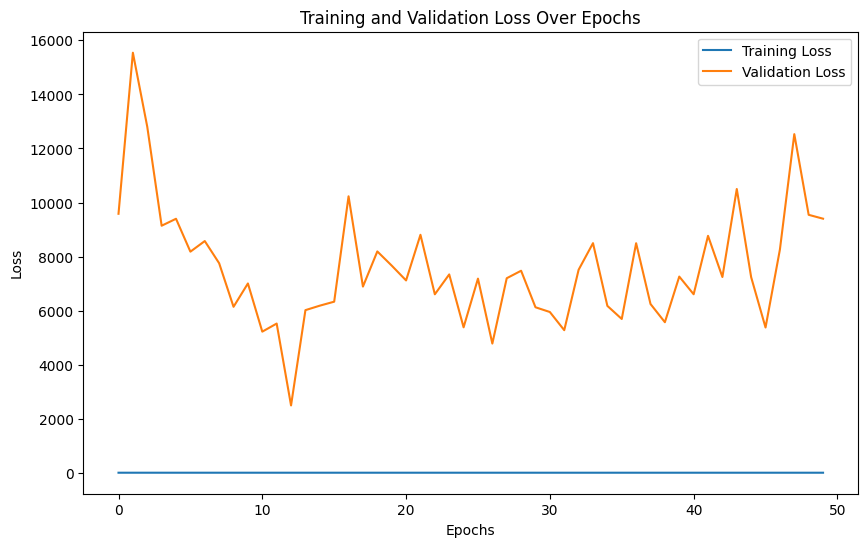

In [88]:
# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Train the model and get the training history
history = dn_model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

# Plot the training and validation loss
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
